In [1]:
import pyfesom2 as pf
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
import cmocean

import matplotlib.tri as mtri
import cartopy.crs as ccrs
from dask.distributed import Client
import dask
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}proxy/{port}/status'})
import gc
import shutil
import os
import seawater as sw
from matplotlib.ticker import LogFormatter


osgeo is not installed, conversion to Geo formats like Geotiff (fesom2GeoFormat) will not work.


In [2]:
yy = 2020
mon = 3

# lons_start = [58, 120.5, 110]
# lons_end = [77.5, 136.5, 139]
# lats_start = [82.5, 77.2, 79]
# lats_end = [85.5, 80.7, 78.5]


lons_start = [72.9]
lons_end = [111.3]
lats_start = [83.5]
lats_end = [81.8]





In [3]:
savefig=True
calc=False

In [4]:
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title


In [5]:
# paths
data_path = '/p/scratch/chhb19/mueller29/AO_40_nopc/'
mesh_path = '/p/project/chhb19/meshes/AO_40/'
out_path = '/p/scratch/chhb19/mueller29/maps/'
plot_path  = '/p/home/jusers/mueller29/juwels/EPICA/plots/figures_paper/'

In [6]:
n_cores = 5
mem_lim = str(int(np.floor(95/n_cores)))+'GB'
if 'client' in locals() or 'client' in globals():
    client.close()
client = Client(n_workers=n_cores, threads_per_worker=1,memory_limit=mem_lim)
client.amm.start()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/vasco.mueller_at_awi.de/r0b111d10d9c453583df569be68e9959/proxy/8787/status,
Dashboard: /user/vasco.mueller_at_awi.de/r0b111d10d9c453583df569be68e9959/proxy/8787/status,Workers: 5
Total threads: 5,Total memory: 88.48 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41589,Workers: 5
Dashboard: /user/vasco.mueller_at_awi.de/r0b111d10d9c453583df569be68e9959/proxy/8787/status,Total threads: 5
Started: Just now,Total memory: 88.48 GiB
Comm: tcp://127.0.0.1:43209,Total threads: 1
Dashboard: /user/vasco.mueller_at_awi.de/r0b111d10d9c453583df569be68e9959/proxy/36715/status,Memory: 17.70 GiB
Nanny: tcp://127.0.0.1:43819,


In [7]:
# chunk sizes
horizontal_split = 1000000
vertical_split = 1
time_split = 1

In [8]:
mesh = pf.load_mesh(mesh_path)
elements = mesh.elem.astype("int32")
lons = mesh.x2
lats = mesh.y2

# for ice interpolate without rotation with lower resolution
d = lons[elements].max(axis=1) - lons[elements].min(axis=1)
no_cyclic_elem = np.argwhere(d < 100).ravel()
triang_ice = mtri.Triangulation(lons, lats, elements[no_cyclic_elem])
depth = -xr.open_dataset((mesh_path+'fesom.mesh.diag.nc'))['zbar_n_bottom'].astype('float32')

/p/project/chhb19/meshes/AO_40/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /p/project/chhb19/meshes/AO_40/pickle_mesh_py3_fesom2


In [9]:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    fit = fit-fit.mean(dim=dim)
    return da - fit

def clim(ds):
    ds_detr = detrend_dim(ds,"time")
    ds_clim = ds_detr.groupby("time.month").mean("time")
    ds_anom = ds.groupby("time.month") - ds_clim
    return ds_clim, ds_anom

In [10]:
top_lvl=0
bottom_lvl = 300
res = 'ultra'

fh_file = out_path+'fh_gridded_'+res+'.npz'
speed_file = out_path+'speed_gridded_'+str(top_lvl)+'_'+str(bottom_lvl)+'average_'+res+'.npz'
eke_sec_file=out_path+'eke_sec.npz'
v_sec_file=out_path+'v_sec.npz'
temp_sec_file=out_path+'temp_sec.npz'
salt_sec_file=out_path+'salt_sec.npz'
fh_sec_file = out_path+'fh_sec.npz'
m_ice_sec_file = out_path+'m_ice_sec.npz'
a_ice_sec_file = out_path+'a_ice_sec.npz'


if calc:
    for sec in range(1,len(lons_start)+1):
        lon_start = lons_start[sec-1]
        lon_end = lons_end[sec-1]
        lat_start = lats_start[sec-1]
        lat_end = lats_end[sec-1]

        
        lonlat=pf.transect_get_lonlat(lon_start, lat_start, lon_end, lat_end,npoints=500)
        nodes = pf.transect_get_nodes(lonlat, mesh)
        d1 = pf.transect_get_distance(lonlat)
        mask2d = pf.transect_get_mask(nodes, mesh, lonlat, max_distance=1e6)
        u=xr.open_dataset((data_path+'unod_monthly.fesom.' + str(yy) + '.nc'),chunks={'time':time_split,'nz1':vertical_split})['unod'].astype('float32')[mon-1,:,:]
        v=xr.open_dataset((data_path+'vnod_monthly.fesom.' + str(yy) + '.nc'),chunks={'time':time_split,'nz1':vertical_split})['vnod'].astype('float32')[mon-1,:,:]
        uu=xr.open_dataset((data_path+'uu.fesom.' + str(yy) + '.nc'),chunks={'time':time_split,'nz1':vertical_split})['uu'].astype('float32')[mon-1,:,:]
        vv=xr.open_dataset((data_path+'vv.fesom.' + str(yy) + '.nc'),chunks={'time':time_split,'nz1':vertical_split})['vv'].astype('float32')[mon-1,:,:]

        u.coords['time']=uu.coords['time'].values
        v.coords['time']=vv.coords['time'].values


        temp=xr.open_dataset((data_path+'temp.fesom.' + str(yy) + '.nc'),chunks={'time':time_split,'nz1':vertical_split})['temp'].astype('float32')[mon-1,:,:]
        salt=xr.open_dataset((data_path+'salt.fesom.' + str(yy) + '.nc'),chunks={'time':time_split,'nz1':vertical_split})['salt'].astype('float32')[mon-1,:,:]

        fh=xr.open_dataset((data_path+'fh_monthly.fesom.' + str(yy) + '.nc'),chunks={'time':time_split,'nz1':vertical_split})['fh'].astype('float32')[mon-1,:]
        z1 = u.nz1.values
        speed = np.sqrt(u**2+v**2)[(z1>=top_lvl)&(z1<=bottom_lvl),:].mean(dim='nz1')
        MKE = 0.5*(u**2+v**2)
        TKE = 0.5*(uu+vv)
        EKE = TKE - MKE
        u, v = pf.vec_rotate_r2g(50, 15, -90, lons, lats, u, v, flag=1)
        
        # define section 1
        eke_section = pf.transect_get_data(EKE.T, nodes, mask2d)
        temp_section = pf.transect_get_data(temp.T, nodes, mask2d)
        salt_section = pf.transect_get_data(salt.T, nodes, mask2d)
        #ma = pf.calculate_initial_compass_bearing((lon_start,lat_start),(lon_end,lat_end))
        d1,u_section,v_section=pf.get_transect_uv(u.T,v.T,mesh,lonlat)
        np.savez_compressed(eke_sec_file,d1=d1, z1=z1, eke_section=eke_section)
        np.savez_compressed(v_sec_file,d1=d1, z1=z1,v_section=v_section)
        np.savez_compressed(temp_sec_file,d1=d1, z1=z1,temp_section=temp_section)
        np.savez_compressed(salt_sec_file,d1=d1, z1=z1,salt_section=salt_section)

        left = -180
        right = 180
        bottom = 65
        top = 90

        #rotated lon/lat
        lons_rot,lats_rot = pf.ut.scalar_g2r(-90,90,90,lons,lats)

        d = lons_rot[elements].max(axis=1) - lons_rot[elements].min(axis=1)
        no_cyclic_elem = np.argwhere(d < 100).ravel()
        triang = mtri.Triangulation(lons_rot, lats_rot, elements[no_cyclic_elem])
        

        zlevs=mesh.zlev

        #zinds=np.argwhere(zlevs==-depth)
        #zinds=zinds[0]


        #regular grid for interpolation
        dx=0.01
        dy=0.01
        nx2=top-bottom+dx #just to make sure the grid isn't square (makes it easier to keep track of dimensions)
        ny2=top-bottom
        lon_eq = np.arange(-nx2, nx2, dx) 
        lat_eq = np.arange(-ny2, ny2, dy)
        nx=lon_eq.shape[0]
        ny=lat_eq.shape[0]

        xx_eq, yy_eq = np.meshgrid(lon_eq, lat_eq)
        xx_eq=xx_eq.T;
        yy_eq=yy_eq.T;
        
        

        
        tri = triang.get_trifinder()

        u_mean = u[(z1>=top_lvl)&(z1<=bottom_lvl),:].mean(axis=0)
        v_mean = v[(z1>=top_lvl)&(z1<=bottom_lvl),:].mean(axis=0)

        m_ice=xr.open_mfdataset((data_path+'m_ice_monthly.fesom.' + str(yy) + '.nc'),chunks={'nod2':horizontal_split})['m_ice'].astype('float32')[mon-1,:]
        a_ice=xr.open_mfdataset((data_path+'a_ice_monthly.fesom.' + str(yy) + '.nc'),chunks={'nod2':horizontal_split})['a_ice'].astype('float32')[mon-1,:]
        fh=xr.open_mfdataset((data_path+'fh_monthly.fesom.' + str(yy) + '.nc'),chunks={'nod2':horizontal_split})['fh'].astype('float32')[mon-1,:]
        
        speed_grid = mtri.LinearTriInterpolator(triang, speed, trifinder=tri)(xx_eq, yy_eq)
        fh_grid = mtri.LinearTriInterpolator(triang, fh, trifinder=tri)(xx_eq, yy_eq)
        u_grid = mtri.LinearTriInterpolator(triang, u_mean, trifinder=tri)(xx_eq, yy_eq)
        v_grid = mtri.LinearTriInterpolator(triang, v_mean, trifinder=tri)(xx_eq, yy_eq)
        
        #save stuff
        np.savez_compressed(fh_file,xx_pol=xx_pol, yy_pol=yy_pol,fh_grid=fh_grid)
        np.savez_compressed(speed_file,xx_pol=xx_pol, yy_pol=yy_pol,speed_grid=speed_grid,u_grid=u_grid,v_grid=v_grid)
        
        it = (fh.time.dt.year==yy)&(fh.time.dt.month==mon)
        fh_section = fh[nodes].values
        m_ice_section = m_ice[nodes].values
        a_ice_section = a_ice[nodes].values
        fh_section = fh_section.flatten()
        m_ice_section = m_ice_section.flatten()
        np.savez_compressed(fh_sec_file,d1=d1, z1=z1,fh_section=fh_section)
        np.savez_compressed(m_ice_sec_file,d1=d1, z1=z1,m_ice_section=m_ice_section)
        np.savez_compressed(a_ice_sec_file,d1=d1, z1=z1,a_ice_section=a_ice_section)
        
else:
    
    xx_pol = np.load(fh_file)['xx_pol']
    yy_pol = np.load(fh_file)['yy_pol']
    fh_grid = np.load(fh_file)['fh_grid']
    speed_grid = np.load(speed_file)['speed_grid']
    u_grid = np.load(speed_file)['u_grid']
    v_grid = np.load(speed_file)['v_grid']

    eke_section = np.load(eke_sec_file)['eke_section']
    d1 = np.load(eke_sec_file)['d1']
    z1 = np.load(eke_sec_file)['z1']
    v_section = np.load(v_sec_file)['v_section']
    temp_section = np.load(temp_sec_file)['temp_section']
    salt_section = np.load(salt_sec_file)['salt_section']
    fp = sw.eos80.fp(salt_section, z1)
    
    fh_section = np.load(fh_sec_file)['fh_section']
    m_ice_section = np.load(m_ice_sec_file)['m_ice_section']
    a_ice_section = np.load(a_ice_sec_file)['a_ice_section']
    
    z_tmp=z1-np.concatenate([np.diff(z1)/2,[0]])

In [11]:
o_path = '/p/project/chhb19/mueller29/data_EKE_paper/'
dout = xr.Dataset(
    data_vars=dict(
        SHF=(['x', 'y'], fh_grid),
    ),
    coords=dict(
        XX=(['x', 'y'], xx_pol),
        YY=(['x', 'y'], yy_pol),
    ),
    attrs=dict(
        description="surface heat flux",
        units="W/m2",
    ),
)     
dout.to_netcdf((o_path+'Fig6_SHF_snapshot.nc'))

dout = xr.Dataset(
    data_vars=dict(
        EKE=(['x', 'z'], eke_section),
    ),
    coords=dict(
        dist=(['x'], d1),
        depth=(['z'], z1),
    ),
    attrs=dict(
        description="EKE section",
        units="m2/s2",
    ),
)     
dout.to_netcdf((o_path+'Fig6_EKE_section.nc'))

dout = xr.Dataset(
    data_vars=dict(
        T_fp=(['x', 'z'], (temp_section-fp)),
    ),
    coords=dict(
        dist=(['x'], d1),
        depth=(['z'], z1),
    ),
    attrs=dict(
        description="T-Tfreezing section",
        units="K",
    ),
)     
dout.to_netcdf((o_path+'Fig6_T_anom_section.nc'))

dout = xr.Dataset(
    data_vars=dict(
        SHF=(['x'], fh_section),
    ),
    coords=dict(
        dist=(['x'], d1),
    ),
    attrs=dict(
        description="surface heat flux",
        units="W/m2",
    ),
)     
dout.to_netcdf((o_path+'Fig6_SHF_section.nc'))

dout = xr.Dataset(
    data_vars=dict(
        m_ice=(['x'], m_ice_section),
    ),
    coords=dict(
        dist=(['x'], d1),
    ),
    attrs=dict(
        description="sea ice thickness",
        units="m",
    ),
)     
dout.to_netcdf((o_path+'Fig6_m_ice_section.nc'))



In [12]:
sec=1
lon_start = lons_start[sec-1]
lon_end = lons_end[sec-1]
lat_start = lats_start[sec-1]
lat_end = lats_end[sec-1]

lonlat=pf.transect_get_lonlat(lon_start, lat_start, lon_end, lat_end,npoints=500)

In [13]:
fig, test_ax = plt.subplots(
    1,
    1,
    constrained_layout=True,
    subplot_kw=dict(projection=ccrs.RotatedPole(pole_longitude=240.0, pole_latitude=45.0, central_rotated_longitude=0.0))
)
test_ax.set_extent([-50,170,77,90], crs=ccrs.PlateCarree())

chartBoxtest=test_ax.get_position()
asp_ratio = chartBoxtest.width/chartBoxtest.height

plt.close()

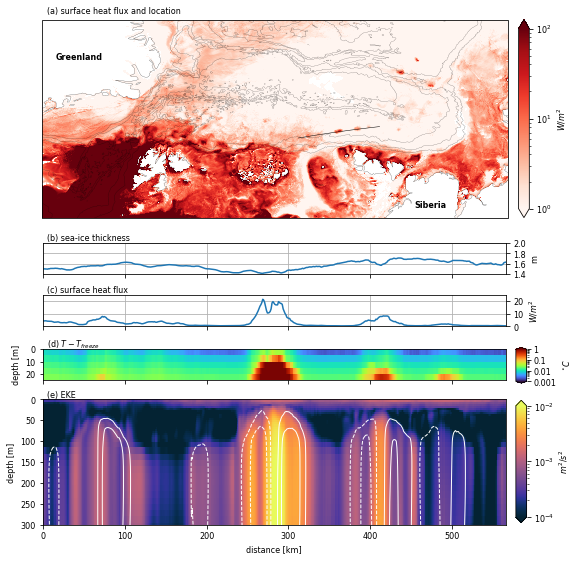

In [14]:
ddd=100
cm2in = 1/2.54  # centimeters in inches
figsize = (19*cm2in, 11.5*cm2in) #1/2 page

levs=np.concatenate([np.arange(-20,0,5),np.arange(5,25,5)]) #contour levels for velocity overlay every 5cm/s

#figure with only 4 subplots -> surf. heat flux added manually because of map projection being stupid
fig, axs = plt.subplots(
    4,
    1,
    constrained_layout=True,
    figsize=figsize,
    sharex=True,
    gridspec_kw={'height_ratios': [1,1,1,4]}
)

#ice thickness
ax=axs[0]
fh_plt = ax.plot(d1,m_ice_section)
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax.set_ylim(bottom=1.4,top=1.8)
ax.set_yticks(np.arange(1.4,2,.2))
ax.grid()
ax.set_ylabel('m', color='k')
ax.text(.01, 1.07, '(b) sea-ice thickness ',zorder=100, transform=ax.transAxes, size=SMALL_SIZE)

#surface heat flux
ax=axs[1]
fh_plt = ax.plot(d1,fh_section)
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax.set_ylim(bottom=0,top=25)
ax.set_yticks(np.arange(0,30,10))
ax.grid()
ax.set_ylabel('$W/m^2$', color='k')
ax.text(.01, 1.07, '(c) surface heat flux ',zorder=100, transform=ax.transAxes, size=SMALL_SIZE)


#temperature above freezing
ax=axs[2]
pc_temp=ax.pcolormesh(d1, z1 , (temp_section-fp).T,cmap = cm.turbo ,shading='auto',norm=colors.LogNorm(vmin=1e-3, vmax=1))
ax.set_ylim(bottom=25,top=0)
ax.set_yticks(np.arange(0,30,10))
ax.set_ylabel('depth [m]', color='k')
ax.text(.01, 1.07, '(d) $T-T_{freeze}$ ',zorder=100, transform=ax.transAxes, size=SMALL_SIZE)


#EKE and meridional velocity
ax=axs[3]
pc_eke=ax.pcolormesh(d1, z1 , eke_section.T , cmap = cmocean.cm.thermal , norm=colors.LogNorm(vmin=1e-4, vmax=1e-2) ,shading='auto')
cont_uv=ax.contour(d1, z_tmp , 100*v_section.T , levels=levs, colors='w',linewidths=1)
ax.set_ylim(bottom=300,top=0)
ax.set_ylabel('depth [m]', color='k')
ax.set_xlabel('distance [km]', color='k')
ax.text(.01, 1.02, '(e) EKE ',zorder=100, transform=ax.transAxes, size=SMALL_SIZE)


#manually add map
chartBox0 = axs[0].get_position()
w = chartBox0.width +.09
map_ax = fig.add_axes([chartBox0.x0-.055,chartBox0.y0-.12,w,w*asp_ratio],projection=ccrs.RotatedPole(pole_longitude=240.0, pole_latitude=45.0, central_rotated_longitude=0.0))

map_ax.set_extent([-50,170,77,90], crs=ccrs.PlateCarree())
#map_ax.set_extent([55,115,80.5,86], crs=ccrs.PlateCarree())

map_ax.coastlines(resolution='50m',linewidths=.2)
#pc_shf = map_ax.pcolormesh(xx_pol[::ddd,::ddd], yy_pol[::ddd,::ddd], fh_grid[::ddd,::ddd], cmap = cm.seismic ,shading='auto',norm=colors.SymLogNorm(linthresh=1, linscale=.25, vmin=-100, vmax=100, base=10), transform=ccrs.PlateCarree())
#pc_shf = map_ax.pcolormesh(xx_pol[::ddd,::ddd], yy_pol[::ddd,::ddd], fh_grid[::ddd,::ddd], cmap = cm.seismic ,shading='auto',norm=colors.TwoSlopeNorm(vcenter=0.,vmin=-10, vmax=100), transform=ccrs.PlateCarree())
pc_shf = map_ax.pcolormesh(xx_pol[::ddd,::ddd], yy_pol[::ddd,::ddd], fh_grid[::ddd,::ddd], cmap = cm.Reds ,shading='auto',norm=colors.LogNorm(vmin=1, vmax=100), transform=ccrs.PlateCarree())

#shading = map_ax.pcolormesh(xx_pol[::ddd,::ddd], yy_pol[::ddd,::ddd], speed_grid[::ddd,::ddd], cmap = cm.Greys ,shading='auto',norm=colors.LogNorm(vmin=1e-2, vmax=1), transform=ccrs.PlateCarree(),alpha=.3)
cont2 = map_ax.tricontour(
    triang_ice,
    depth,
    [1000,2000,3000,4000,5000],
    transform=ccrs.PlateCarree(),
    colors='k',
    linewidths=.2,
    alpha=.7
)
line=map_ax.plot(lonlat[0,:],lonlat[1,:],'k',linewidth=.5, transform=ccrs.PlateCarree())
map_ax.text(.01, 1.03, '(a) surface heat flux and location',zorder=100, transform=map_ax.transAxes, size=SMALL_SIZE)


chartBox0 = axs[0].get_position()
chartBox = map_ax.get_position()


tt=map_ax.text(.03, .8, 'Greenland',zorder=100, transform=map_ax.transAxes, size=8,color='k', weight='bold')
tt.set_bbox(dict(facecolor='white', alpha=.5, edgecolor='none',pad=0))
tt=map_ax.text(.8, .05, 'Siberia',zorder=100, transform=map_ax.transAxes, size=8,color='k', weight='bold')
tt.set_bbox(dict(facecolor='white', alpha=.5, edgecolor='none',pad=0))



# add the colorbars

formatter = LogFormatter(10, labelOnlyBase=False) 

chartBox1 = map_ax.get_position()
cbar_ax = fig.add_axes([chartBox1.x0+chartBox1.width+0.02, chartBox1.y0, 0.02, chartBox1.height])
cb_shf=fig.colorbar(pc_shf,cax=cbar_ax,orientation="vertical",extend='both')
cb_shf.set_label(r'$W/m^2$', size=SMALL_SIZE)
#cb_shf.ax.set_yscale('linear')

chartBox1 = axs[2].get_position()
cbar_ax = fig.add_axes([chartBox1.x0+chartBox1.width+0.05, chartBox1.y0, 0.02, chartBox1.height+.015])
cbar_temp=fig.colorbar(pc_temp,cax=cbar_ax,orientation="vertical",extend='both',ticks=[0.001,0.01,0.1,1], format=formatter)
cbar_temp.ax.set_yticklabels(['0.001', '0.01', '0.1', '1'])  # vertically oriented colorbar
cbar_temp.set_label(' $^{\circ}C$')

chartBox1 = axs[3].get_position()
cbar_ax = fig.add_axes([chartBox1.x0+chartBox1.width+0.05, chartBox1.y0-0.02, 0.02, chartBox1.height])
cb_eke=fig.colorbar(pc_eke,cax=cbar_ax,orientation="vertical",extend='both')
cb_eke.set_label(r'$m^2/s^2$', size=SMALL_SIZE)


if savefig:
    fig.savefig(plot_path + 'F6_EKE_temp_section_'+str(yy)+str(mon).zfill(2)+'_large_map.png', dpi=400, format='png',bbox_inches='tight',pad_inches=0)

In [13]:
fig, test_ax = plt.subplots(
    1,
    1,
    constrained_layout=True,
    subplot_kw=dict(projection=ccrs.RotatedPole(pole_longitude=240.0, pole_latitude=45.0, central_rotated_longitude=0.0))
)
#test_ax.set_extent([-50,170,77,90], crs=ccrs.PlateCarree())
#test_ax.set_extent([60,115,80.5,84], crs=ccrs.PlateCarree())
test_ax.set_extent([60,115,82,84], crs=ccrs.PlateCarree())

chartBoxtest=test_ax.get_position()
asp_ratio = chartBoxtest.width/chartBoxtest.height
plt.close()

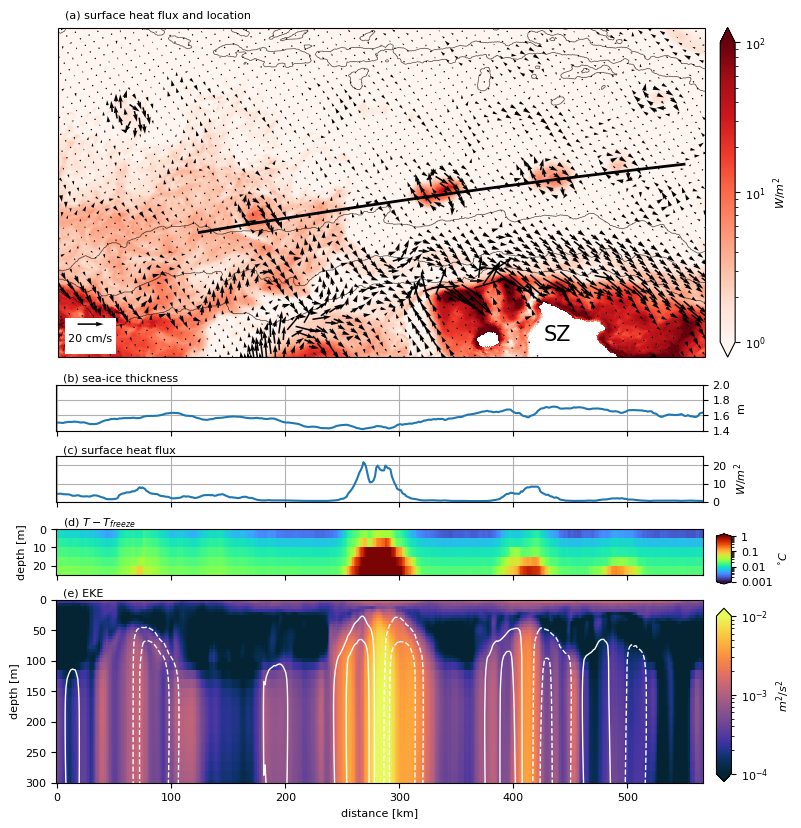

In [19]:
ddd=1
cm2in = 1/2.54  # centimeters in inches
figsize = (19*cm2in, 11.5*cm2in) #1/2 page

levs=np.concatenate([np.arange(-20,0,5),np.arange(5,25,5)]) #contour levels for velocity overlay every 5cm/s

#figure with only 4 subplots -> surf. heat flux added manually because of map projection being stupid
fig, axs = plt.subplots(
    4,
    1,
    constrained_layout=True,
    figsize=figsize,
    sharex=True,
    gridspec_kw={'height_ratios': [1,1,1,4]}
)

#ice thickness
ax=axs[0]
fh_plt = ax.plot(d1,m_ice_section)
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax.set_ylim(bottom=1.4,top=1.8)
ax.set_yticks(np.arange(1.4,2,.2))
ax.grid()
ax.set_ylabel('m', color='k')
ax.text(.01, 1.07, '(b) sea-ice thickness ',zorder=100, transform=ax.transAxes, size=SMALL_SIZE)

#surface heat flux
ax=axs[1]
fh_plt = ax.plot(d1,fh_section)
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax.set_ylim(bottom=0,top=25)
ax.set_yticks(np.arange(0,30,10))
ax.grid()
ax.set_ylabel('$W/m^2$', color='k')
ax.text(.01, 1.07, '(c) surface heat flux ',zorder=100, transform=ax.transAxes, size=SMALL_SIZE)


#temperature above freezing
ax=axs[2]
pc_temp=ax.pcolormesh(d1, z1 , (temp_section-fp).T,cmap = cm.turbo ,shading='auto',norm=colors.LogNorm(vmin=1e-3, vmax=1))
ax.set_ylim(bottom=25,top=0)
ax.set_yticks(np.arange(0,30,10))
ax.set_ylabel('depth [m]', color='k')
ax.text(.01, 1.07, '(d) $T-T_{freeze}$ ',zorder=100, transform=ax.transAxes, size=SMALL_SIZE)


#EKE and meridional velocity
ax=axs[3]
pc_eke=ax.pcolormesh(d1, z1 , eke_section.T , cmap = cmocean.cm.thermal , norm=colors.LogNorm(vmin=1e-4, vmax=1e-2) ,shading='auto')

cont_uv_s=ax.contour(d1, z_tmp , 100*v_section.T , levels=np.arange(-20,0,5), colors='w',linewidths=1,linestyles = 'dashed')
cont_uv_n=ax.contour(d1, z_tmp , 100*v_section.T , levels=np.arange(5,25,5), colors='w',linewidths=1,linestyles = 'solid')

ax.set_ylim(bottom=300,top=0)
ax.set_ylabel('depth [m]', color='k')
ax.set_xlabel('distance [km]', color='k')
ax.text(.01, 1.02, '(e) EKE ',zorder=100, transform=ax.transAxes, size=SMALL_SIZE)


#manually add map
chartBox0 = axs[0].get_position()
w = chartBox0.width +.09
map_ax = fig.add_axes([chartBox0.x0-.055,chartBox0.y0-.03,w,w*asp_ratio],projection=ccrs.RotatedPole(pole_longitude=240.0, pole_latitude=45.0, central_rotated_longitude=0.0))

map_ax.set_extent([60,115,82,84], crs=ccrs.PlateCarree())

#map_ax.coastlines(resolution='50m',linewidths=.5)
pc_shf = map_ax.pcolormesh(xx_pol[::ddd,::ddd], yy_pol[::ddd,::ddd], fh_grid[::ddd,::ddd], cmap = cm.Reds ,shading='auto',norm=colors.LogNorm(vmin=1, vmax=100), transform=ccrs.PlateCarree())
quiv = map_ax.quiver(xx_pol[::10,::10],yy_pol[::10,::10],u_grid[::10,::10],v_grid[::10,::10],transform=ccrs.PlateCarree(),scale=5)

#shading = map_ax.pcolormesh(xx_pol[::ddd,::ddd], yy_pol[::ddd,::ddd], speed_grid[::ddd,::ddd], cmap = cm.Greys ,shading='auto',norm=colors.LogNorm(vmin=1e-2, vmax=1), transform=ccrs.PlateCarree(),alpha=.3)
cont2 = map_ax.tricontour(
    triang_ice,
    depth,
    [1000,2000,3000,4000,5000],
    transform=ccrs.PlateCarree(),
    colors='k',
    linewidths=.5,
    alpha=.7
)
line=map_ax.plot(lonlat[0,:],lonlat[1,:],'k',linewidth=2, transform=ccrs.PlateCarree())
map_ax.text(.01, 1.03, '(a) surface heat flux and location',zorder=100, transform=map_ax.transAxes, size=SMALL_SIZE)
map_ax.text(.75, .05, 'SZ',zorder=100, transform=map_ax.transAxes, size=MEDIUM_SIZE)

#key = map_ax.quiverkey(quiv, 0.025, 1.15, 0.2, "20 cm/s", coordinates='figure', labelpos='S', fontproperties={'size':SMALL_SIZE})
import matplotlib.patches as patches
# Create a rectangle patch using relative axes coordinates
rectangle = patches.Rectangle((0.01, 0.01), 0.08, 0.11, fill=True, facecolor='white',zorder=2, transform=map_ax.transAxes)
# Add the rectangle patch to the subplot
map_ax.add_patch(rectangle)
rectangle.set_zorder(2)
key = map_ax.quiverkey(quiv, 0.05, 0.1, 0.2, "20 cm/s", coordinates='axes', labelpos='S', fontproperties={'size':SMALL_SIZE},zorder=3)
key.set_zorder(3)

chartBox0 = axs[0].get_position()


# tt=map_ax.text(.03, .8, 'Greenland',zorder=100, transform=map_ax.transAxes, size=8,color='k', weight='bold')
# tt.set_bbox(dict(facecolor='white', alpha=.5, edgecolor='none',pad=0))
# tt=map_ax.text(.8, .05, 'Siberia',zorder=100, transform=map_ax.transAxes, size=8,color='k', weight='bold')
# tt.set_bbox(dict(facecolor='white', alpha=.5, edgecolor='none',pad=0))



# add the colorbars

formatter = LogFormatter(10, labelOnlyBase=False) 

chartBox1 = map_ax.get_position()
cbar_ax = fig.add_axes([chartBox1.x0+chartBox1.width+0.02, chartBox1.y0, 0.02, chartBox1.height])
cb_shf=fig.colorbar(pc_shf,cax=cbar_ax,orientation="vertical",extend='both')
cb_shf.set_label(r'$W/m^2$', size=SMALL_SIZE)
#cb_shf.ax.set_yscale('linear')

chartBox1 = axs[2].get_position()
cbar_ax = fig.add_axes([chartBox1.x0+chartBox1.width+0.05, chartBox1.y0, 0.02, chartBox1.height+.015])
cbar_temp=fig.colorbar(pc_temp,cax=cbar_ax,orientation="vertical",extend='both',ticks=[0.001,0.01,0.1,1], format=formatter)
cbar_temp.ax.set_yticklabels(['0.001', '0.01', '0.1', '1'])  # vertically oriented colorbar
cbar_temp.set_label(' $^{\circ}C$')

chartBox1 = axs[3].get_position()
cbar_ax = fig.add_axes([chartBox1.x0+chartBox1.width+0.05, chartBox1.y0-0.02, 0.02, chartBox1.height])
cb_eke=fig.colorbar(pc_eke,cax=cbar_ax,orientation="vertical",extend='both')
cb_eke.set_label(r'$m^2/s^2$', size=SMALL_SIZE)




if savefig:
    fig.savefig(plot_path + 'F6_EKE_temp_section_'+str(yy)+str(mon).zfill(2)+'_small_map.png', dpi=400, format='png',bbox_inches='tight',pad_inches=0)

In [21]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='110m')

plt.show()

ValueError: Incomplete shapefile definition in '/p/home/jusers/mueller29/juwels/.local/share/cartopy/shapefiles/natural_earth/physical/ne_110m_coastline.shp'.

<Figure size 640x480 with 1 Axes>